In [1]:
import findspark
findspark.init()

from pyspark import SparkContext
sc = SparkContext("local", "pyspark-shell")

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

from pyspark.sql.types import StructField, StructType, LongType, StringType, DoubleType
a = StructType([StructField("NO",LongType(),True),StructField("MLSID",StringType(),True),StructField("STREETNUMBERNUMERIC",LongType(),True),StructField("STREETADDRESS",StringType(),True),StructField("STREETNAME",StringType(),True),StructField("POSTALCODE",LongType(),True),StructField("STATEORPROVINCE",StringType(),True),StructField("CITY",StringType(),True),StructField("SALESCLOSEPRICE",LongType(),True),StructField("LISTDATE",StringType(),True),StructField("LISTPRICE",LongType(),True),StructField("LISTTYPE",StringType(),True),StructField("ORIGINALLISTPRICE",LongType(),True),StructField("PRICEPERTSFT",DoubleType(),True),StructField("FOUNDATIONSIZE",LongType(),True),StructField("FENCE",StringType(),True),StructField("MAPLETTER",StringType(),True),StructField("LOTSIZEDIMENSIONS",StringType(),True),StructField("SCHOOLDISTRICTNUMBER",StringType(),True),StructField("DAYSONMARKET",LongType(),True),StructField("OFFMARKETDATE",StringType(),True),StructField("FIREPLACES",LongType(),True),StructField("ROOMAREA4",StringType(),True),StructField("ROOMTYPE",StringType(),True),StructField("ROOF",StringType(),True),StructField("ROOMFLOOR4",StringType(),True),StructField("POTENTIALSHORTSALE",StringType(),True),StructField("POOLDESCRIPTION",StringType(),True),StructField("PDOM",LongType(),True),StructField("GARAGEDESCRIPTION",StringType(),True),StructField("SQFTABOVEGROUND",LongType(),True),StructField("TAXES",LongType(),True),StructField("ROOMFLOOR1",StringType(),True),StructField("ROOMAREA1",StringType(),True),StructField("TAXWITHASSESSMENTS",DoubleType(),True),StructField("TAXYEAR",LongType(),True),StructField("LIVINGAREA",LongType(),True),StructField("UNITNUMBER",StringType(),True),StructField("YEARBUILT",LongType(),True),StructField("ZONING",StringType(),True),StructField("STYLE",StringType(),True),StructField("ACRES",DoubleType(),True),StructField("COOLINGDESCRIPTION",StringType(),True),StructField("APPLIANCES",StringType(),True),StructField("BACKONMARKETDATE",DoubleType(),True),StructField("ROOMFAMILYCHAR",StringType(),True),StructField("ROOMAREA3",StringType(),True),StructField("EXTERIOR",StringType(),True),StructField("ROOMFLOOR3",StringType(),True),StructField("ROOMFLOOR2",StringType(),True),StructField("ROOMAREA2",StringType(),True),StructField("DININGROOMDESCRIPTION",StringType(),True),StructField("BASEMENT",StringType(),True),StructField("BATHSFULL",LongType(),True),StructField("BATHSHALF",LongType(),True),StructField("BATHQUARTER",LongType(),True),StructField("BATHSTHREEQUARTER",DoubleType(),True),StructField("CLASS",StringType(),True),StructField("BATHSTOTAL",LongType(),True),StructField("BATHDESC",StringType(),True),StructField("ROOMAREA5",StringType(),True),StructField("ROOMFLOOR5",StringType(),True),StructField("ROOMAREA6",StringType(),True),StructField("ROOMFLOOR6",StringType(),True),StructField("ROOMAREA7",StringType(),True),StructField("ROOMFLOOR7",StringType(),True),StructField("ROOMAREA8",StringType(),True),StructField("ROOMFLOOR8",StringType(),True),StructField("BEDROOMS",LongType(),True),StructField("SQFTBELOWGROUND",LongType(),True),StructField("ASSUMABLEMORTGAGE",StringType(),True),StructField("ASSOCIATIONFEE",LongType(),True),StructField("ASSESSMENTPENDING",StringType(),True),StructField("ASSESSEDVALUATION",DoubleType(),True)])
df = spark.read.csv("Real_Estate.csv", header=True, schema=a)

# Feature Engineering

## Feature Generation

Creating new features can better capture patterns in the data. Combining features together can capture subtle dependent effects between them that impact the outcome variable. These can be represented by multiplying, summing, differencing or dividing two or more variables (multiplying width and length for example). Applying your reasoning and understanding of the problem can help you build powerful predictors.

There is no limit how many features you can combine but the interpretability certainly takes a steep dive after three. Beyond this is the realm of deep feature generation. 

### Differences

In [2]:
acres_to_sqfeet = 43560

df = df.withColumn("LOT_SIZE_SQFT", df["ACRES"] * acres_to_sqfeet)
df = df.withColumn("YARD_SIZE", df["LOT_SIZE_SQFT"] - df["FOUNDATIONSIZE"])

print("Corr of ACRES vs SALESCLOSEPRICE" + str(df.corr("SALESCLOSEPRICE", "ACRES")))
print("Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE: " + str(df.corr("SALESCLOSEPRICE", "FOUNDATIONSIZE")))
print("Corr of YARD_SIZE vs SALESCLOSEPRICE: " + str(df.corr("SALESCLOSEPRICE", "YARD_SIZE")))

Corr of ACRES vs SALESCLOSEPRICE0.22060612588935333
Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE: 0.6152231695664402
Corr of YARD_SIZE vs SALESCLOSEPRICE: 0.20714585430854263


Not all generated features are worthwhile, many are not but its still worth doing! Most likely this is because there isn't a lot of variation in lot sizes in the neighborhoods we are looking at to create a strong feature. In addition if we look at our data, some of the homes have 0 ACRES if we really wanted to handle this correctly we could have to set the minimum YARD_SIZE to 0.

### Ratios

In [3]:
df = df.withColumn("ASSESSED_TO_LIST", df["ASSESSEDVALUATION"] / df["LISTPRICE"])
df[['ASSESSEDVALUATION', 'LISTPRICE', 'ASSESSED_TO_LIST']].show(5)

df = df.withColumn("TAX_TO_LIST", df["TAXES"] / df["LISTPRICE"])
df[['TAX_TO_LIST', 'TAXES', 'LISTPRICE']].show(5)

df = df.withColumn("BED_TO_BATHS", df["BEDROOMS"] / df["BATHSTOTAL"])
df[['BED_TO_BATHS', 'BEDROOMS', 'BATHSTOTAL']].show(5)

+-----------------+---------+----------------+
|ASSESSEDVALUATION|LISTPRICE|ASSESSED_TO_LIST|
+-----------------+---------+----------------+
|              0.0|   139900|             0.0|
|              0.0|   210000|             0.0|
|              0.0|   225000|             0.0|
|              0.0|   230000|             0.0|
|              0.0|   239900|             0.0|
+-----------------+---------+----------------+
only showing top 5 rows

+--------------------+-----+---------+
|         TAX_TO_LIST|TAXES|LISTPRICE|
+--------------------+-----+---------+
|0.013280914939242315| 1858|   139900|
| 0.00780952380952381| 1640|   210000|
|0.010622222222222222| 2390|   225000|
|0.009330434782608695| 2146|   230000|
|0.008378491037932471| 2010|   239900|
+--------------------+-----+---------+
only showing top 5 rows

+------------------+--------+----------+
|      BED_TO_BATHS|BEDROOMS|BATHSTOTAL|
+------------------+--------+----------+
|               1.5|       3|         2|
|1.333333333

### Deeper Features


+-------+-------------------+
|summary| BATHS_PER_1000SQFT|
+-------+-------------------+
|  count|               5000|
|   mean| 1.4302617483739894|
| stddev|  14.12890410245937|
|    min|0.39123630672926446|
|    max|             1000.0|
+-------+-------------------+



C:\anaconda3\lib\site-packages\seaborn\axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
C:\anaconda3\lib\site-packages\seaborn\axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


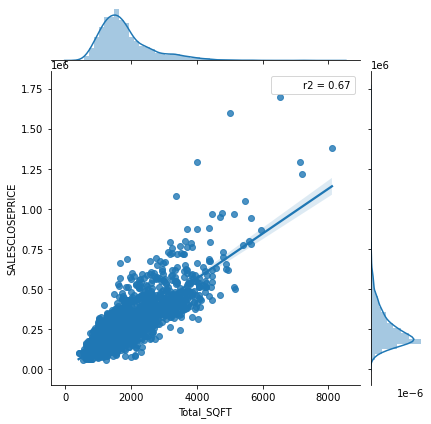

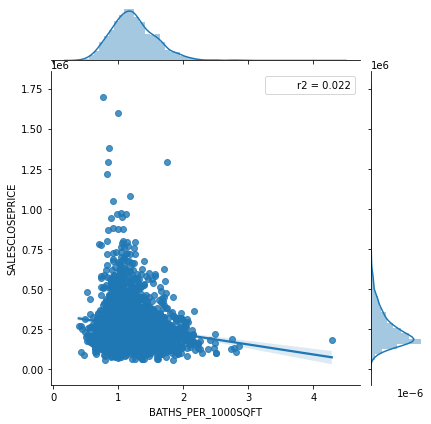

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns


df = df.withColumn("Total_SQFT", df["SQFTBELOWGROUND"] + df["SQFTABOVEGROUND"])
df = df.withColumn("BATHS_PER_1000SQFT", df["BATHSTOTAL"] / (df["Total_SQFT"] / 1000))
df[["BATHS_PER_1000SQFT"]].describe().show()

pandas_df = df.sample(False, 0.5, 0).toPandas()

from scipy import stats

def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

sns.jointplot(x="Total_SQFT", y="SALESCLOSEPRICE", data = pandas_df, kind="reg", stat_func=r2)
sns.jointplot(x="BATHS_PER_1000SQFT", y="SALESCLOSEPRICE", data = pandas_df, kind="reg", stat_func=r2)
plt.show()

Using the describe() function you could have seen there was a max of 1000 bathrooms per 1000sqft, which is almost for sure an issue with our data. If you really wanted to use this feature you'd have to filter that outlier out or overwrite it to NULL with when(). After plotting the jointplots()s you should have seen that the less complicated feature Total_SQFT had a much better R2 of 0.67 vs BATHS_PER_1000SQFT's 0.02. Often simplier is better!

## Time Features

Usin time in our models is not as easy as throwing it into our model as a continuous variable.

The high variation in the daily number of homes sold makes this pattern hard for us to see and the model to understand. If we change the aggregation to look at grouping by month we can see the pattern much more clearly. Choosing the right level to build out time-related features is important. If it is too granular they are too noisy for our model, too broad and our model misses trends.

To work with dates we need them to be of Spark date type. Conversion can be done by using to_data function. If you need the time component use to_timestamp instead. You can convert them into ordinal features like year or month using the functions year and month respectively. dayofmonth(), weekofyear()...

You can use lag function with window funtion to compate the current record. Window allows you to return the value for each record based on some calculation against a group of records such as rank or moving average.

### Time Components

Since the "LISTDATE" column was not provided accurately, some conversions has been done. The values of the column converted into required shape to be recognized by to_timestamp function.

In [8]:
a = StructType([StructField("NO",LongType(),True),StructField("MLSID",StringType(),True),StructField("STREETNUMBERNUMERIC",LongType(),True),StructField("STREETADDRESS",StringType(),True),StructField("STREETNAME",StringType(),True),StructField("POSTALCODE",LongType(),True),StructField("STATEORPROVINCE",StringType(),True),StructField("CITY",StringType(),True),StructField("SALESCLOSEPRICE",LongType(),True),StructField("LISTDATE",StringType(),True),StructField("LISTPRICE",LongType(),True),StructField("LISTTYPE",StringType(),True),StructField("ORIGINALLISTPRICE",LongType(),True),StructField("PRICEPERTSFT",DoubleType(),True),StructField("FOUNDATIONSIZE",LongType(),True),StructField("FENCE",StringType(),True),StructField("MAPLETTER",StringType(),True),StructField("LOTSIZEDIMENSIONS",StringType(),True),StructField("SCHOOLDISTRICTNUMBER",StringType(),True),StructField("DAYSONMARKET",LongType(),True),StructField("OFFMARKETDATE",StringType(),True),StructField("FIREPLACES",LongType(),True),StructField("ROOMAREA4",StringType(),True),StructField("ROOMTYPE",StringType(),True),StructField("ROOF",StringType(),True),StructField("ROOMFLOOR4",StringType(),True),StructField("POTENTIALSHORTSALE",StringType(),True),StructField("POOLDESCRIPTION",StringType(),True),StructField("PDOM",LongType(),True),StructField("GARAGEDESCRIPTION",StringType(),True),StructField("SQFTABOVEGROUND",LongType(),True),StructField("TAXES",LongType(),True),StructField("ROOMFLOOR1",StringType(),True),StructField("ROOMAREA1",StringType(),True),StructField("TAXWITHASSESSMENTS",DoubleType(),True),StructField("TAXYEAR",LongType(),True),StructField("LIVINGAREA",LongType(),True),StructField("UNITNUMBER",StringType(),True),StructField("YEARBUILT",LongType(),True),StructField("ZONING",StringType(),True),StructField("STYLE",StringType(),True),StructField("ACRES",DoubleType(),True),StructField("COOLINGDESCRIPTION",StringType(),True),StructField("APPLIANCES",StringType(),True),StructField("BACKONMARKETDATE",DoubleType(),True),StructField("ROOMFAMILYCHAR",StringType(),True),StructField("ROOMAREA3",StringType(),True),StructField("EXTERIOR",StringType(),True),StructField("ROOMFLOOR3",StringType(),True),StructField("ROOMFLOOR2",StringType(),True),StructField("ROOMAREA2",StringType(),True),StructField("DININGROOMDESCRIPTION",StringType(),True),StructField("BASEMENT",StringType(),True),StructField("BATHSFULL",LongType(),True),StructField("BATHSHALF",LongType(),True),StructField("BATHQUARTER",LongType(),True),StructField("BATHSTHREEQUARTER",DoubleType(),True),StructField("CLASS",StringType(),True),StructField("BATHSTOTAL",LongType(),True),StructField("BATHDESC",StringType(),True),StructField("ROOMAREA5",StringType(),True),StructField("ROOMFLOOR5",StringType(),True),StructField("ROOMAREA6",StringType(),True),StructField("ROOMFLOOR6",StringType(),True),StructField("ROOMAREA7",StringType(),True),StructField("ROOMFLOOR7",StringType(),True),StructField("ROOMAREA8",StringType(),True),StructField("ROOMFLOOR8",StringType(),True),StructField("BEDROOMS",LongType(),True),StructField("SQFTBELOWGROUND",LongType(),True),StructField("ASSUMABLEMORTGAGE",StringType(),True),StructField("ASSOCIATIONFEE",LongType(),True),StructField("ASSESSMENTPENDING",StringType(),True),StructField("ASSESSEDVALUATION",DoubleType(),True)])
df = spark.read.csv("Real_Estate.csv", header=True, schema=a)
from pyspark.sql.functions import split, format_string, concat_ws, to_timestamp


df = df.withColumn("LISTDATE1", split(df.LISTDATE, " ")[0])

df = df.withColumn("day", split(df.LISTDATE1, "/")[0])
df = df.withColumn("month", split(df.LISTDATE1, "/")[1])
df = df.withColumn("year", split(df.LISTDATE1, "/")[2])

df = df.withColumn("day", df.day.cast("int"))
df = df.withColumn("month", df.month.cast("int"))
df = df.withColumn("day",format_string("%02d", "day"))
df = df.withColumn("month",format_string("%02d", "month"))

df = df.withColumn("day", df.day.cast("string"))
df = df.withColumn("month", df.month.cast("string"))
df = df.withColumn( "a",concat_ws('/',df.day,df.month,df.year))
df = df.withColumn( "a",concat_ws('/',df.month,df.day,df.year))
df = df.withColumn("LISTDATE", to_timestamp("a","dd/MM/yyyy"))

df = df.drop("a")
df = df.drop("day")
df = df.drop("year")
df = df.drop("a")

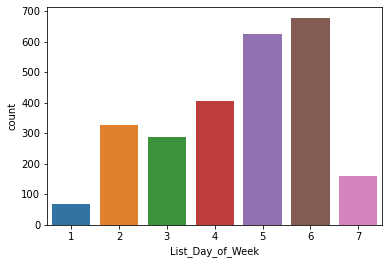

In [9]:
from pyspark.sql.functions import to_date, dayofweek

df = df.withColumn("LISTDATE", to_date("LISTDATE"))
df = df.withColumn("List_Day_of_Week", dayofweek("LISTDATE"))
sample_df = df.sample(False, 0.5, 42).toPandas()
sns.countplot(x="List_Day_of_Week", data=sample_df)
plt.show()

### Joining On Time Components

In [21]:
from pyspark.sql.functions import year

median_prices_df = spark.read.csv("median_prices.csv", header=True)

df = df.withColumn("list_year", year("LISTDATE"))
df = df.withColumn("report_year", df.list_year-1)

condition = [df["CITY"] == median_prices_df["City"], df["report_year"] == median_prices_df["Year"]]

df = df.join(median_prices_df, on=condition, how="left")
df[["MedianHomeValue"]].show()

+---------------+
|MedianHomeValue|
+---------------+
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
+---------------+
only showing top 20 rows



### Date Math

In [43]:
from pyspark.sql.functions import lag, datediff, to_date
from pyspark.sql.window import Window

mort_df = spark.read.csv("mort.csv",header=True)
mort_df = mort_df.withColumn("DATE", to_date("DATE","yyyy-MM-dd"))

w = Window().orderBy(mort_df["DATE"])
mort_df = mort_df.withColumn("DATE-1", lag("DATE", 1).over(w))

mort_df = mort_df.withColumn("Days_Between_Report", datediff("DATE", "DATE-1"))

mort_df.select("DATE", "DATE-1", "Days_Between_Report").show()

mort_df.select("Days_Between_Report").distinct().show()

+----------+----------+-------------------+
|      DATE|    DATE-1|Days_Between_Report|
+----------+----------+-------------------+
|2013-10-10|      null|               null|
|2013-10-17|2013-10-10|                  7|
|2013-10-24|2013-10-17|                  7|
|2013-10-31|2013-10-24|                  7|
|2013-11-07|2013-10-31|                  7|
|2013-11-14|2013-11-07|                  7|
|2013-11-21|2013-11-14|                  7|
|2013-11-27|2013-11-21|                  6|
|2013-12-05|2013-11-27|                  8|
|2013-12-12|2013-12-05|                  7|
|2013-12-19|2013-12-12|                  7|
|2013-12-26|2013-12-19|                  7|
|2014-01-02|2013-12-26|                  7|
|2014-01-09|2014-01-02|                  7|
|2014-01-16|2014-01-09|                  7|
|2014-01-23|2014-01-16|                  7|
|2014-01-30|2014-01-23|                  7|
|2014-02-06|2014-01-30|                  7|
|2014-02-13|2014-02-06|                  7|
|2014-02-20|2014-02-13|         

## Extracting Features

Wrangle columns into useful information for machine learning. You can extract features by using split and when functions. If the order of the listed values in a column is not guaranteed you can use explode so that each value has a separate record, with everything else repeated. Then you can pivot those repeated field into columns. For this you need split, explod, lit, coalesce and first functions. 

### Extracting Text to New Features

In [53]:
from pyspark.sql.functions import when

has_attached_garage = df["GARAGEDESCRIPTION"].like("%Attached Garage%")
has_detached_garage = df["GARAGEDESCRIPTION"].like("%Detached Garage%")

df = df.withColumn("has_attached_garage", (when(has_attached_garage, 1)
                                          .when(has_detached_garage, 0)
                                          .otherwise(None)))

df[["GARAGEDESCRIPTION", "has_attached_garage"]].show(truncate=False)

+------------------------------------------------------------------+-------------------+
|GARAGEDESCRIPTION                                                 |has_attached_garage|
+------------------------------------------------------------------+-------------------+
|Attached Garage                                                   |1                  |
|Attached Garage, Driveway - Asphalt, Garage Door Opener           |1                  |
|Attached Garage                                                   |1                  |
|Attached Garage, Detached Garage, Tuckunder, Driveway - Gravel    |1                  |
|Attached Garage, Driveway - Asphalt, Garage Door Opener           |1                  |
|Attached Garage, Driveway - Asphalt                               |1                  |
|Attached Garage, Driveway - Asphalt, Garage Door Opener           |1                  |
|Attached Garage                                                   |1                  |
|Attached Garage     

### Splitting & Exploding


In [54]:
from pyspark.sql.functions import explode

df = df.withColumn("garage_list", split("GARAGEDESCRIPTION", ", "))
ex_df = df.withColumn("ex_garage_list", explode("garage_list"))
ex_df[["ex_garage_list"]].distinct().show(100, truncate=50)

+----------------------------+
|              ex_garage_list|
+----------------------------+
|             Attached Garage|
|      On-Street Parking Only|
|                        None|
| More Parking Onsite for Fee|
|          Garage Door Opener|
|   No Int Access to Dwelling|
|           Driveway - Gravel|
|       Valet Parking for Fee|
|              Uncovered/Open|
|               Heated Garage|
|          Underground Garage|
|                       Other|
|                  Unassigned|
|More Parking Offsite for Fee|
|    Driveway - Other Surface|
|       Contract Pkg Required|
|                     Carport|
|                     Secured|
|             Detached Garage|
|          Driveway - Asphalt|
|                  Units Vary|
|                    Assigned|
|                   Tuckunder|
|                     Covered|
|            Insulated Garage|
|         Driveway - Concrete|
|                      Tandem|
|           Driveway - Shared|
+----------------------------+



It looks like there is a decent amount of values here but not hundreds. If you have too many, when you pivot them it can make your dataset a mess.

### Pivot & Join


In [79]:
from pyspark.sql.functions import coalesce, first, lit

ex_df = ex_df.withColumn("constant_val", lit(1))
piv_df = ex_df.groupBy("NO").pivot("ex_garage_list").agg(coalesce(first("constant_val")))

joined_df = df.join(piv_df,on="NO", how="left")

zfill_cols = piv_df.columns
zfilled_df = joined_df.fillna(0,subset=zfill_cols)
zfilled_df.select("NO", "Attached Garage", "Detached Garage", "Carport").show()

+----+---------------+---------------+-------+
|  NO|Attached Garage|Detached Garage|Carport|
+----+---------------+---------------+-------+
|  26|              1|              0|      0|
|  29|              1|              1|      0|
| 474|              1|              0|      0|
| 964|              1|              0|      0|
|1677|              1|              0|      0|
|1697|              0|              1|      0|
|1806|              0|              1|      0|
|1950|              0|              1|      0|
|2040|              0|              1|      0|
|2214|              0|              0|      0|
|2250|              0|              1|      0|
|2453|              1|              0|      0|
|2509|              0|              1|      0|
|2529|              0|              1|      0|
|2927|              0|              1|      0|
|3091|              0|              1|      0|
|3506|              0|              1|      0|
|3764|              0|              1|      0|
|4590|       

In [80]:
zfilled_df.orderBy("NO").select("NO", "Attached Garage", "Detached Garage", "Carport").show()

+---+---------------+---------------+-------+
| NO|Attached Garage|Detached Garage|Carport|
+---+---------------+---------------+-------+
|  1|              1|              0|      0|
|  2|              1|              0|      0|
|  3|              1|              0|      0|
|  4|              1|              1|      0|
|  5|              1|              0|      0|
|  6|              1|              0|      0|
|  7|              1|              0|      0|
|  8|              1|              0|      0|
|  9|              1|              0|      0|
| 10|              1|              0|      0|
| 11|              1|              0|      0|
| 12|              1|              0|      0|
| 13|              1|              0|      0|
| 14|              1|              0|      0|
| 15|              1|              0|      0|
| 16|              1|              0|      0|
| 17|              1|              0|      0|
| 18|              1|              0|      0|
| 19|              1|             

## Binarizing, Bucketing & Encoding


Binarization of data is a helpful way to collapse some nuance in your model to just a yes/no. Bucketing, also known as binning is a way to create ordinal variables. ML algorithms connat handle categorical data like a text field. It must be converted to a numberic format to be evaluated correctly. For that StringIndexer and onehatencoder to output all the encoded indexes to a single column of type vector which is more efficient than storing them all individual columns.

### Binarizing Day of Week

In [85]:
from pyspark.ml.feature import Binarizer

binarizer = Binarizer(threshold=5, inputCol="List_Day_of_Week", outputCol="Listed_On_Weekend")
df = df.withColumn("List_Day_of_Week", df["List_Day_of_Week"].cast("double"))
df = binarizer.transform(df)
df[["List_Day_of_Week", "Listed_On_Weekend"]].show()

+----------------+-----------------+
|List_Day_of_Week|Listed_On_Weekend|
+----------------+-----------------+
|             7.0|              1.0|
|             2.0|              0.0|
|             2.0|              0.0|
|             6.0|              1.0|
|             3.0|              0.0|
|             2.0|              0.0|
|             5.0|              0.0|
|             1.0|              0.0|
|             5.0|              0.0|
|             7.0|              1.0|
|             6.0|              1.0|
|             5.0|              0.0|
|             1.0|              0.0|
|             2.0|              0.0|
|             5.0|              0.0|
|             1.0|              0.0|
|             1.0|              0.0|
|             6.0|              1.0|
|             7.0|              1.0|
|             6.0|              1.0|
+----------------+-----------------+
only showing top 20 rows



### Bucketing

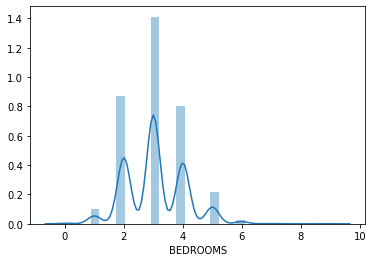

+--------+--------+
|BEDROOMS|bedrooms|
+--------+--------+
|     3.0|     3.0|
|     4.0|     4.0|
|     2.0|     2.0|
|     2.0|     2.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     2.0|     2.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
+--------+--------+
only showing top 20 rows



In [93]:
from pyspark.ml.feature import Bucketizer

sample_df = df.select("BEDROOMS").sample(False, 0.5).toPandas()
sns.distplot(sample_df, axlabel="BEDROOMS")
plt.show()

splits = [0, 1, 2, 3, 4, 5, float("Inf")]
buck = Bucketizer(splits=splits, inputCol="BEDROOMS", outputCol="bedrooms")
df_bucket = buck.transform(df)
df_bucket[["BEDROOMS", "bedrooms"]].show()

Being able to inspect a distribution plot is important if you are considering bucketing feature values together.

### One Hot Encoding

Convert SCHOOLDISTRICTNUMBER from a categorial variable into a numeric vector

In [96]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

string_indexer = StringIndexer(inputCol="SCHOOLDISTRICTNUMBER", outputCol="School_Index")
indexed_df = string_indexer.fit(df).transform(df)

encoder = OneHotEncoder(inputCol="School_Index", outputCol="School_Vec")
encoded_df = encoder.fit(indexed_df).transform(indexed_df)

encoded_df[["SCHOOLDISTRICTNUMBER", "School_Index", "School_Vec"]].show(truncate=False)

+-----------------------------+------------+-------------+
|SCHOOLDISTRICTNUMBER         |School_Index|School_Vec   |
+-----------------------------+------------+-------------+
|834 - Stillwater             |3.0         |(7,[3],[1.0])|
|834 - Stillwater             |3.0         |(7,[3],[1.0])|
|622 - North St Paul-Maplewood|1.0         |(7,[1],[1.0])|
|834 - Stillwater             |3.0         |(7,[3],[1.0])|
|622 - North St Paul-Maplewood|1.0         |(7,[1],[1.0])|
|834 - Stillwater             |3.0         |(7,[3],[1.0])|
|834 - Stillwater             |3.0         |(7,[3],[1.0])|
|834 - Stillwater             |3.0         |(7,[3],[1.0])|
|834 - Stillwater             |3.0         |(7,[3],[1.0])|
|834 - Stillwater             |3.0         |(7,[3],[1.0])|
|834 - Stillwater             |3.0         |(7,[3],[1.0])|
|834 - Stillwater             |3.0         |(7,[3],[1.0])|
|834 - Stillwater             |3.0         |(7,[3],[1.0])|
|834 - Stillwater             |3.0         |(7,[3],[1.0]